In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline

In [3]:
# Cargar datos adicionales de admisiones para crear features agregados
df_admission = pd.read_csv("./data/cleaned_admission_data.csv")
df_admission['admission_date'] = pd.to_datetime(df_admission['admission_date'])
df_admission['discharge_date'] = pd.to_datetime(df_admission['discharge_date'])

# Expandir el rango de fechas por paciente
df_expanded = (
    df_admission
    .apply(lambda row: pd.date_range(row['admission_date'], row['discharge_date'], freq='D'), axis=1)
    .explode()
    .to_frame(name='date')
)

# Agregar el ID del paciente
df_expanded['serial_number'] = df_admission.loc[df_expanded.index, 'serial_number'].values

# Unir con los datos completos del paciente
df_expanded = df_expanded.merge(
    df_admission[['serial_number', 'age', 'gender', 'admission_type', 'diabetes', 
                  'hypertension', 'coronary_artery_disease', 'heart_failure']],
    on='serial_number',
    how='left'
)

# Crear variables dummy
df_expanded['male'] = (df_expanded['gender'] == 'M').astype(int)
df_expanded['emergency'] = (df_expanded['admission_type'] == 'E').astype(int)

# Agrupar por fecha y crear features agregados
daily_features = df_expanded.groupby('date').agg({
    'age': 'mean',
    'male': 'mean',
    'emergency': 'mean',
    'diabetes': 'mean',
    'hypertension': 'mean',
    'coronary_artery_disease': 'mean',
    'heart_failure': 'mean'
}).reset_index()

# Renombrar columnas
daily_features.columns = ['date', 'avg_age', 'pct_male', 'pct_emergency',
                         'pct_diabetes', 'pct_hypertension', 'pct_cad', 'pct_heart_failure']

# Excluir últimos 25 valores (como en MLP para evitar sesgo)
daily_features = daily_features.iloc[:-25]

print(f"Features agregados creados: {daily_features.shape}")
print(daily_features.head())


Features agregados creados: (728, 8)
        date    avg_age  pct_male  pct_emergency  pct_diabetes  \
0 2017-04-01  57.133333  0.633333       0.733333      0.466667   
1 2017-04-02  59.466667  0.644444       0.733333      0.511111   
2 2017-04-03  59.507692  0.753846       0.630769      0.446154   
3 2017-04-04  57.525641  0.705128       0.628205      0.371795   
4 2017-04-05  57.619718  0.661972       0.633803      0.338028   

   pct_hypertension   pct_cad  pct_heart_failure  
0          0.533333  0.400000           0.366667  
1          0.533333  0.466667           0.355556  
2          0.523077  0.538462           0.230769  
3          0.487179  0.500000           0.192308  
4          0.535211  0.563380           0.183099  


In [4]:
# Cargar datos de pacientes hospitalizados por día (ya procesados)
daily_counts = pd.read_csv("./data/daily_hospitalized_patients.csv")
# Parsear fechas
daily_counts['date'] = pd.to_datetime(daily_counts['date'])

# Cargar datos climáticos
df_weather = pd.read_csv("./data/HDHI_pollution_data.csv")

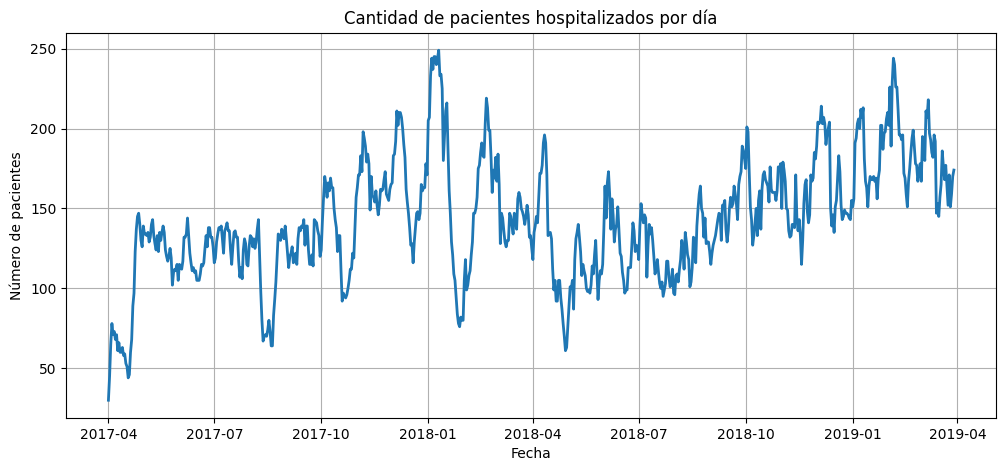

In [5]:
# Visualizar serie temporal de pacientes hospitalizados por día
plt.figure(figsize=(12,5))
plt.plot(daily_counts['date'], daily_counts['num_patients'], linewidth=2)
plt.title('Cantidad de pacientes hospitalizados por día')
plt.xlabel('Fecha')
plt.ylabel('Número de pacientes')
plt.grid(True)
plt.show()

In [6]:
# Procesar datos climáticos (igual que en 03_MLP.ipynb)
df_weather['DATE'] = pd.to_datetime(df_weather['DATE'], dayfirst=False, errors='coerce')

# Columnas de interés (mismas que en 03_MLP.ipynb)
wanted = ['DATE', 'AQI', 'MAX TEMP', 'MIN TEMP', 'HUMIDITY']
present = [c for c in wanted if c in df_weather.columns]

# Seleccionar y, si hay duplicados por fecha, agregarlos por media
dfw_sel = df_weather[present].copy()
if dfw_sel['DATE'].duplicated().any():
    dfw_sel = dfw_sel.groupby('DATE', as_index=False).mean()

# Merge por fecha (left join para conservar daily_counts)
daily_counts['date'] = pd.to_datetime(daily_counts['date'], errors='coerce')
df_weather_merged = pd.merge(daily_counts, dfw_sel, left_on='date', right_on='DATE', how='left')

# Limpiar/renombrar columnas para análisis posterior
df_weather_merged = df_weather_merged.drop(columns=['DATE'], errors='ignore').rename(
    columns={
        'AQI': 'aqi',
        'MAX TEMP': 'max_temp',
        'MIN TEMP': 'min_temp',
        'HUMIDITY': 'humidity'
    }
)

# Forzar numérico en las columnas añadidas
for col in ['aqi', 'max_temp', 'min_temp', 'humidity']:
    if col in df_weather_merged.columns:
        df_weather_merged[col] = pd.to_numeric(df_weather_merged[col], errors='coerce')

# Rellenar valores faltantes de humedad con la media (como en 03_MLP.ipynb)
mean_humidity = df_weather_merged['humidity'].mean()
df_weather_merged['humidity'] = df_weather_merged['humidity'].fillna(mean_humidity).round(2)

# Seleccionar solo las columnas climáticas para df_weather
df_weather = df_weather_merged[['date', 'aqi', 'max_temp', 'min_temp', 'humidity']].copy()

# Preparar daily_counts y daily_features (excluir últimos 25 valores para consistencia)
daily_counts_processed = daily_counts.iloc[:-25].copy()
daily_features_processed = daily_features.copy()


EXPERIMENTO 1: Random Forest con solo daily_counts

Resultados Experimento 1:
MAE: 11.33
R²: 0.646
Features utilizadas: 7 (solo lags)


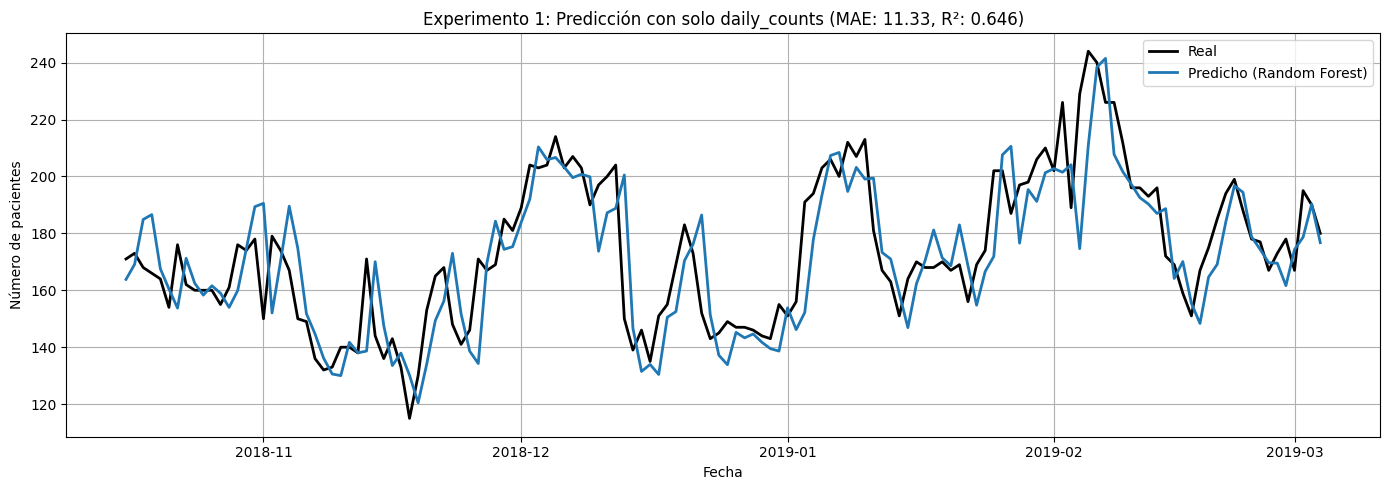


--- Pronóstico a 7 días futuros (Experimento 1) ---

Predicción a 7 días:
  Día 1: 177 pacientes
  Día 2: 180 pacientes
  Día 3: 179 pacientes
  Día 4: 181 pacientes
  Día 5: 173 pacientes
  Día 6: 176 pacientes
  Día 7: 178 pacientes


In [7]:
# ============================================================================
# EXPERIMENTO 1: Solo daily_counts
# ============================================================================
print("=" * 70)
print("EXPERIMENTO 1: Random Forest con solo daily_counts")
print("=" * 70)

# Preparar datos
df_exp1 = daily_counts_processed.copy()

# Crear variables de rezago (lags)
for lag in range(1, 8):  # memoria de 7 días
    df_exp1[f'lag_{lag}'] = df_exp1['num_patients'].shift(lag)

df_exp1 = df_exp1.dropna().reset_index(drop=True)

# Variables predictoras y target
feature_cols_exp1 = [col for col in df_exp1.columns if col not in ['date', 'num_patients']]
X_exp1 = df_exp1[feature_cols_exp1]
y_exp1 = df_exp1['num_patients']

# División temporal train/test
split_idx_exp1 = int(len(df_exp1) * 0.8)
X_train_exp1, X_test_exp1 = X_exp1.iloc[:split_idx_exp1], X_exp1.iloc[split_idx_exp1:]
y_train_exp1, y_test_exp1 = y_exp1.iloc[:split_idx_exp1], y_exp1.iloc[split_idx_exp1:]

# Pipeline Random Forest
rf_pipeline_exp1 = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ))
])

# Entrenamiento
rf_pipeline_exp1.fit(X_train_exp1, y_train_exp1)

# Evaluación
y_pred_exp1 = rf_pipeline_exp1.predict(X_test_exp1)
mae_exp1 = mean_absolute_error(y_test_exp1, y_pred_exp1)
r2_exp1 = r2_score(y_test_exp1, y_pred_exp1)

print(f"\nResultados Experimento 1:")
print(f"MAE: {mae_exp1:.2f}")
print(f"R²: {r2_exp1:.3f}")
print(f"Features utilizadas: {len(feature_cols_exp1)} (solo lags)")

# Visualización
plt.figure(figsize=(14, 5))
plt.plot(df_exp1['date'].iloc[split_idx_exp1:], y_test_exp1.values, 
         label='Real', color='black', linewidth=2)
plt.plot(df_exp1['date'].iloc[split_idx_exp1:], y_pred_exp1, 
         label='Predicho (Random Forest)', color='tab:blue', linewidth=2)
plt.title(f'Experimento 1: Predicción con solo daily_counts (MAE: {mae_exp1:.2f}, R²: {r2_exp1:.3f})')
plt.xlabel('Fecha')
plt.ylabel('Número de pacientes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Pronóstico a 7 días futuros
print("\n--- Pronóstico a 7 días futuros (Experimento 1) ---")
last_7_patients = df_exp1['num_patients'].iloc[-7:].values
future_preds_exp1 = []

for i in range(7):
    # Crear lags: lag_1 es el más reciente (hace 1 día), lag_7 es el más antiguo (hace 7 días)
    # Si last_7_patients = [v1, v2, v3, v4, v5, v6, v7] donde v7 es el más reciente
    # lag_1 = v6 (hace 1 día), lag_2 = v5, ..., lag_7 = v1 (hace 7 días)
    lags = last_7_patients[-7:] if len(last_7_patients) >= 7 else last_7_patients
    lag_dict = {f'lag_{j+1}': lags[-(j+1)] for j in range(7)}
    X_future_df = pd.DataFrame([lag_dict], columns=feature_cols_exp1)
    y_future = rf_pipeline_exp1.predict(X_future_df)[0]
    future_preds_exp1.append(y_future)
    # Actualizar la ventana con la nueva predicción (desplazar y agregar la nueva)
    last_7_patients = np.append(last_7_patients[1:], y_future)

print("\nPredicción a 7 días:")
for i, val in enumerate(future_preds_exp1, start=1):
    print(f"  Día {i}: {round(val)} pacientes")


EXPERIMENTO 2: Random Forest con daily_counts + daily_features

Resultados Experimento 2:
MAE: 11.40
R²: 0.647
Features utilizadas: 14 (lags + features agregados)


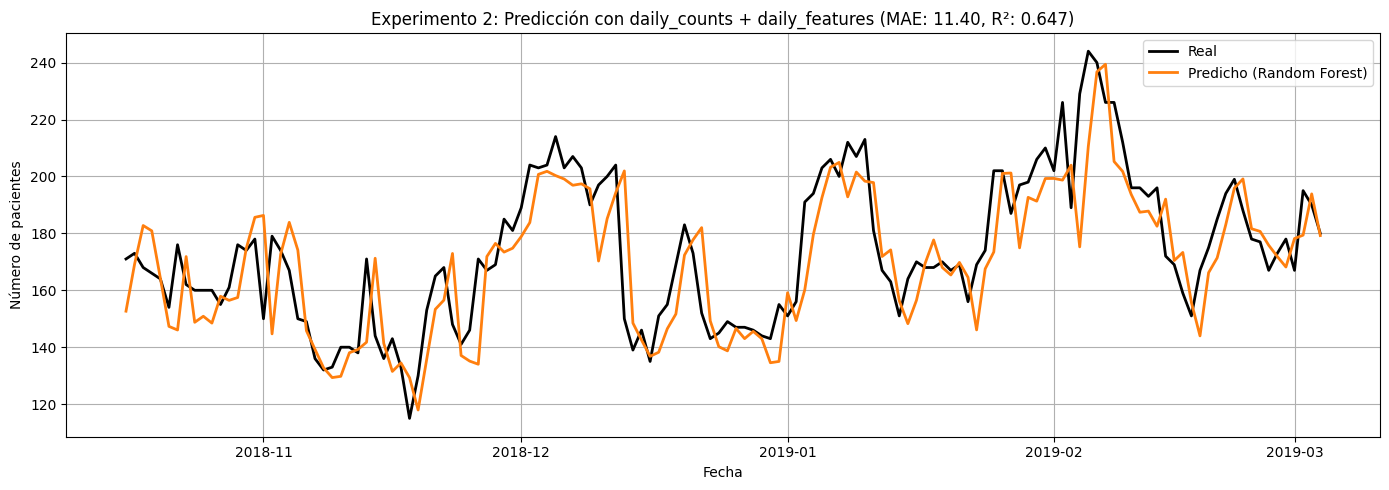


--- Pronóstico a 7 días futuros (Experimento 2) ---

Predicción a 7 días:
  Día 1: 181 pacientes
  Día 2: 181 pacientes
  Día 3: 179 pacientes
  Día 4: 179 pacientes
  Día 5: 176 pacientes
  Día 6: 179 pacientes
  Día 7: 178 pacientes


In [8]:
# ============================================================================
# EXPERIMENTO 2: daily_counts + daily_features
# ============================================================================
print("\n" + "=" * 70)
print("EXPERIMENTO 2: Random Forest con daily_counts + daily_features")
print("=" * 70)

# Preparar datos
df_exp2 = pd.merge(daily_counts_processed, daily_features_processed, on='date', how='inner')

# Crear variables de rezago (lags)
for lag in range(1, 8):  # memoria de 7 días
    df_exp2[f'lag_{lag}'] = df_exp2['num_patients'].shift(lag)

df_exp2 = df_exp2.dropna().reset_index(drop=True)

# Variables predictoras y target
feature_cols_exp2 = [col for col in df_exp2.columns if col not in ['date', 'num_patients']]
X_exp2 = df_exp2[feature_cols_exp2]
y_exp2 = df_exp2['num_patients']

# División temporal train/test
split_idx_exp2 = int(len(df_exp2) * 0.8)
X_train_exp2, X_test_exp2 = X_exp2.iloc[:split_idx_exp2], X_exp2.iloc[split_idx_exp2:]
y_train_exp2, y_test_exp2 = y_exp2.iloc[:split_idx_exp2], y_exp2.iloc[split_idx_exp2:]

# Pipeline Random Forest
rf_pipeline_exp2 = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ))
])

# Entrenamiento
rf_pipeline_exp2.fit(X_train_exp2, y_train_exp2)

# Evaluación
y_pred_exp2 = rf_pipeline_exp2.predict(X_test_exp2)
mae_exp2 = mean_absolute_error(y_test_exp2, y_pred_exp2)
r2_exp2 = r2_score(y_test_exp2, y_pred_exp2)

print(f"\nResultados Experimento 2:")
print(f"MAE: {mae_exp2:.2f}")
print(f"R²: {r2_exp2:.3f}")
print(f"Features utilizadas: {len(feature_cols_exp2)} (lags + features agregados)")

# Visualización
plt.figure(figsize=(14, 5))
plt.plot(df_exp2['date'].iloc[split_idx_exp2:], y_test_exp2.values, 
         label='Real', color='black', linewidth=2)
plt.plot(df_exp2['date'].iloc[split_idx_exp2:], y_pred_exp2, 
         label='Predicho (Random Forest)', color='tab:orange', linewidth=2)
plt.title(f'Experimento 2: Predicción con daily_counts + daily_features (MAE: {mae_exp2:.2f}, R²: {r2_exp2:.3f})')
plt.xlabel('Fecha')
plt.ylabel('Número de pacientes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Pronóstico a 7 días futuros
print("\n--- Pronóstico a 7 días futuros (Experimento 2) ---")
last_row = df_exp2.iloc[-1]
future_preds_exp2 = []

# Obtener los últimos 7 valores de pacientes
last_7_patients = df_exp2['num_patients'].iloc[-7:].values
# Obtener las últimas features conocidas (se repetirán para los 7 días)
last_features_dict = {col: last_row[col] for col in df_exp2.columns if col not in ['date', 'num_patients'] and not col.startswith('lag_')}

for i in range(7):
    # Crear lags: lag_1 es el más reciente (hace 1 día), lag_7 es el más antiguo (hace 7 días)
    lags = last_7_patients[-7:] if len(last_7_patients) >= 7 else last_7_patients
    lags_dict = {f'lag_{j+1}': lags[-(j+1)] for j in range(7)}
    # Combinar lags con features
    X_future_dict = {**lags_dict, **last_features_dict}
    X_future_df = pd.DataFrame([X_future_dict], columns=feature_cols_exp2)
    y_future = rf_pipeline_exp2.predict(X_future_df)[0]
    future_preds_exp2.append(y_future)
    # Actualizar la ventana con la nueva predicción (desplazar y agregar la nueva)
    last_7_patients = np.append(last_7_patients[1:], y_future)

print("\nPredicción a 7 días:")
for i, val in enumerate(future_preds_exp2, start=1):
    print(f"  Día {i}: {round(val)} pacientes")



EXPERIMENTO 3: Random Forest con daily_counts + daily_features + df_weather

Resultados Experimento 3:
MAE: 10.86
R²: 0.676
Features utilizadas: 18 (lags + features agregados + clima)


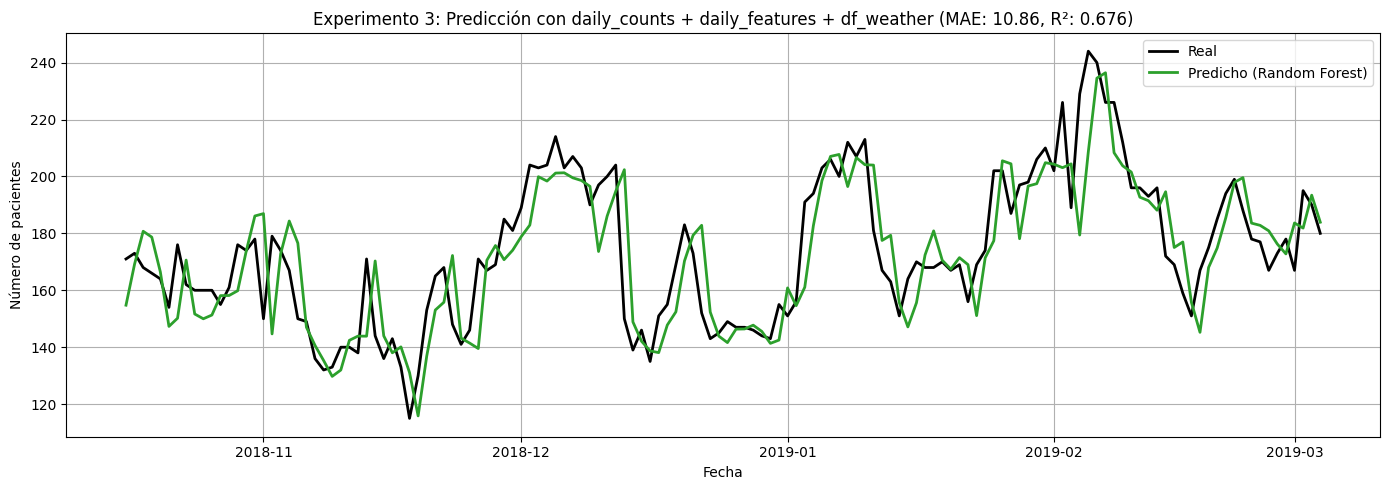


--- Pronóstico a 7 días futuros (Experimento 3) ---

Predicción a 7 días:
  Día 1: 184 pacientes
  Día 2: 181 pacientes
  Día 3: 184 pacientes
  Día 4: 184 pacientes
  Día 5: 181 pacientes
  Día 6: 183 pacientes
  Día 7: 184 pacientes


In [9]:
# ============================================================================
# EXPERIMENTO 3: daily_counts + daily_features + df_weather
# ============================================================================
print("\n" + "=" * 70)
print("EXPERIMENTO 3: Random Forest con daily_counts + daily_features + df_weather")
print("=" * 70)

# Preparar datos
df_exp3 = pd.merge(daily_counts_processed, daily_features_processed, on='date', how='inner')
df_exp3 = pd.merge(df_exp3, df_weather, on='date', how='inner')

# Crear variables de rezago (lags)
for lag in range(1, 8):  # memoria de 7 días
    df_exp3[f'lag_{lag}'] = df_exp3['num_patients'].shift(lag)

df_exp3 = df_exp3.dropna().reset_index(drop=True)

# Variables predictoras y target
feature_cols_exp3 = [col for col in df_exp3.columns if col not in ['date', 'num_patients']]
X_exp3 = df_exp3[feature_cols_exp3]
y_exp3 = df_exp3['num_patients']

# División temporal train/test
split_idx_exp3 = int(len(df_exp3) * 0.8)
X_train_exp3, X_test_exp3 = X_exp3.iloc[:split_idx_exp3], X_exp3.iloc[split_idx_exp3:]
y_train_exp3, y_test_exp3 = y_exp3.iloc[:split_idx_exp3], y_exp3.iloc[split_idx_exp3:]

# Pipeline Random Forest
rf_pipeline_exp3 = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ))
])

# Entrenamiento
rf_pipeline_exp3.fit(X_train_exp3, y_train_exp3)

# Evaluación
y_pred_exp3 = rf_pipeline_exp3.predict(X_test_exp3)
mae_exp3 = mean_absolute_error(y_test_exp3, y_pred_exp3)
r2_exp3 = r2_score(y_test_exp3, y_pred_exp3)

print(f"\nResultados Experimento 3:")
print(f"MAE: {mae_exp3:.2f}")
print(f"R²: {r2_exp3:.3f}")
print(f"Features utilizadas: {len(feature_cols_exp3)} (lags + features agregados + clima)")

# Visualización
plt.figure(figsize=(14, 5))
plt.plot(df_exp3['date'].iloc[split_idx_exp3:], y_test_exp3.values, 
         label='Real', color='black', linewidth=2)
plt.plot(df_exp3['date'].iloc[split_idx_exp3:], y_pred_exp3, 
         label='Predicho (Random Forest)', color='tab:green', linewidth=2)
plt.title(f'Experimento 3: Predicción con daily_counts + daily_features + df_weather (MAE: {mae_exp3:.2f}, R²: {r2_exp3:.3f})')
plt.xlabel('Fecha')
plt.ylabel('Número de pacientes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Pronóstico a 7 días futuros
print("\n--- Pronóstico a 7 días futuros (Experimento 3) ---")
last_7_patients = df_exp3['num_patients'].iloc[-7:].values
# Obtener las últimas features conocidas (se usarán para los 7 días)
future_features_rows = df_exp3.iloc[-7:]
future_preds_exp3 = []

for i in range(7):
    # Crear lags: lag_1 es el más reciente (hace 1 día), lag_7 es el más antiguo (hace 7 días)
    lags = last_7_patients[-7:] if len(last_7_patients) >= 7 else last_7_patients
    lags_dict = {f'lag_{j+1}': lags[-(j+1)] for j in range(7)}
    # Obtener features del día correspondiente (o la última si no hay más)
    features_idx = min(i, len(future_features_rows) - 1)
    features_row = future_features_rows.iloc[features_idx]
    # Obtener features no-lag
    features_dict = {col: features_row[col] for col in df_exp3.columns if col not in ['date', 'num_patients'] and not col.startswith('lag_')}
    # Combinar lags con features
    X_future_dict = {**lags_dict, **features_dict}
    X_future_df = pd.DataFrame([X_future_dict], columns=feature_cols_exp3)
    y_future = rf_pipeline_exp3.predict(X_future_df)[0]
    future_preds_exp3.append(y_future)
    # Actualizar la ventana con la nueva predicción (desplazar y agregar la nueva)
    last_7_patients = np.append(last_7_patients[1:], y_future)

print("\nPredicción a 7 días:")
for i, val in enumerate(future_preds_exp3, start=1):
    print(f"  Día {i}: {round(val)} pacientes")


EXPERIMENTO 4: Random Forest con daily_counts + df_weather

Resultados Experimento 4:
MAE: 10.88
R²: 0.676
Features utilizadas: 11 (lags + clima)


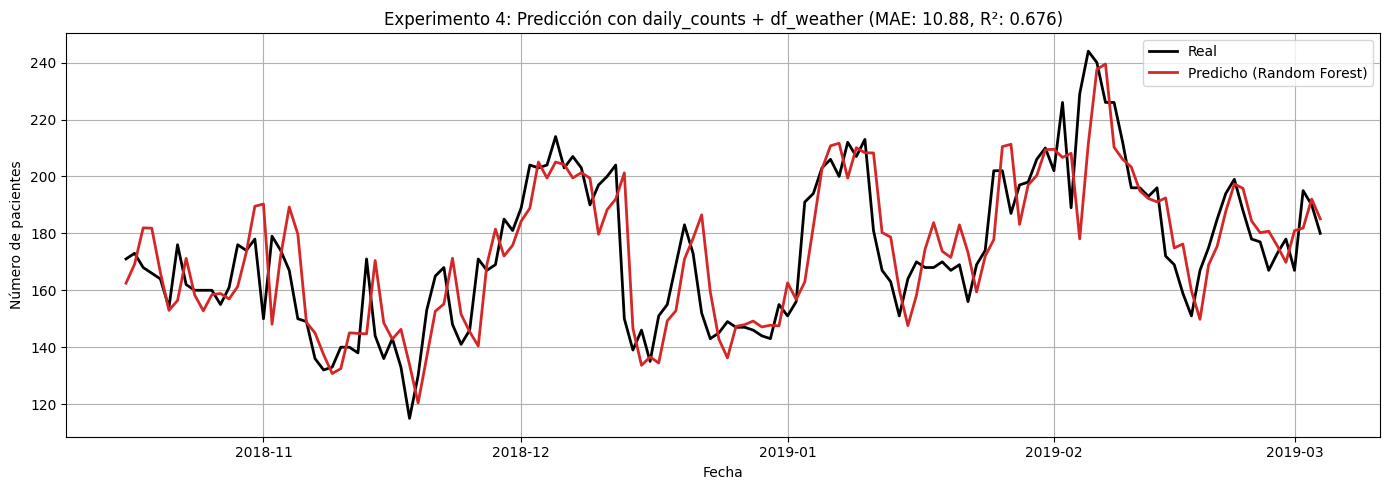


--- Pronóstico a 7 días futuros (Experimento 4) ---

Predicción a 7 días:
  Día 1: 185 pacientes
  Día 2: 187 pacientes
  Día 3: 181 pacientes
  Día 4: 179 pacientes
  Día 5: 178 pacientes
  Día 6: 183 pacientes
  Día 7: 180 pacientes


In [10]:
# ============================================================================
# EXPERIMENTO 4: daily_counts + df_weather
# ============================================================================
print("\n" + "=" * 70)
print("EXPERIMENTO 4: Random Forest con daily_counts + df_weather")
print("=" * 70)

# Preparar datos
df_exp4 = pd.merge(daily_counts_processed, df_weather, on='date', how='inner')

# Crear variables de rezago (lags)
for lag in range(1, 8):  # memoria de 7 días
    df_exp4[f'lag_{lag}'] = df_exp4['num_patients'].shift(lag)

df_exp4 = df_exp4.dropna().reset_index(drop=True)

# Variables predictoras y target
feature_cols_exp4 = [col for col in df_exp4.columns if col not in ['date', 'num_patients']]
X_exp4 = df_exp4[feature_cols_exp4]
y_exp4 = df_exp4['num_patients']

# División temporal train/test
split_idx_exp4 = int(len(df_exp4) * 0.8)
X_train_exp4, X_test_exp4 = X_exp4.iloc[:split_idx_exp4], X_exp4.iloc[split_idx_exp4:]
y_train_exp4, y_test_exp4 = y_exp4.iloc[:split_idx_exp4], y_exp4.iloc[split_idx_exp4:]

# Pipeline Random Forest
rf_pipeline_exp4 = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ))
])

# Entrenamiento
rf_pipeline_exp4.fit(X_train_exp4, y_train_exp4)

# Evaluación
y_pred_exp4 = rf_pipeline_exp4.predict(X_test_exp4)
mae_exp4 = mean_absolute_error(y_test_exp4, y_pred_exp4)
r2_exp4 = r2_score(y_test_exp4, y_pred_exp4)

print(f"\nResultados Experimento 4:")
print(f"MAE: {mae_exp4:.2f}")
print(f"R²: {r2_exp4:.3f}")
print(f"Features utilizadas: {len(feature_cols_exp4)} (lags + clima)")

# Visualización
plt.figure(figsize=(14, 5))
plt.plot(df_exp4['date'].iloc[split_idx_exp4:], y_test_exp4.values, 
         label='Real', color='black', linewidth=2)
plt.plot(df_exp4['date'].iloc[split_idx_exp4:], y_pred_exp4, 
         label='Predicho (Random Forest)', color='tab:red', linewidth=2)
plt.title(f'Experimento 4: Predicción con daily_counts + df_weather (MAE: {mae_exp4:.2f}, R²: {r2_exp4:.3f})')
plt.xlabel('Fecha')
plt.ylabel('Número de pacientes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Pronóstico a 7 días futuros
print("\n--- Pronóstico a 7 días futuros (Experimento 4) ---")
last_7_patients = df_exp4['num_patients'].iloc[-7:].values
# Obtener las últimas features climáticas conocidas (se usarán para los 7 días)
future_weather_rows = df_exp4.iloc[-7:]
future_preds_exp4 = []

for i in range(7):
    # Crear lags: lag_1 es el más reciente (hace 1 día), lag_7 es el más antiguo (hace 7 días)
    lags = last_7_patients[-7:] if len(last_7_patients) >= 7 else last_7_patients
    lags_dict = {f'lag_{j+1}': lags[-(j+1)] for j in range(7)}
    # Obtener features climáticas del día correspondiente (o la última si no hay más)
    weather_idx = min(i, len(future_weather_rows) - 1)
    weather_row = future_weather_rows.iloc[weather_idx]
    # Obtener features no-lag (climáticas)
    weather_dict = {col: weather_row[col] for col in df_exp4.columns if col not in ['date', 'num_patients'] and not col.startswith('lag_')}
    # Combinar lags con features climáticas
    X_future_dict = {**lags_dict, **weather_dict}
    X_future_df = pd.DataFrame([X_future_dict], columns=feature_cols_exp4)
    y_future = rf_pipeline_exp4.predict(X_future_df)[0]
    future_preds_exp4.append(y_future)
    # Actualizar la ventana con la nueva predicción (desplazar y agregar la nueva)
    last_7_patients = np.append(last_7_patients[1:], y_future)

print("\nPredicción a 7 días:")
for i, val in enumerate(future_preds_exp4, start=1):
    print(f"  Día {i}: {round(val)} pacientes")



COMPARACIÓN DE RESULTADOS DE LOS CUATRO EXPERIMENTOS

Tabla comparativa:
                                  Experimento       MAE       R²  Features
                         1: Solo daily_counts 11.329830 0.645527         7
             2: daily_counts + daily_features 11.397916 0.647420        14
3: daily_counts + daily_features + df_weather 10.862107 0.675971        18
                 4: daily_counts + df_weather 10.878403 0.676292        11


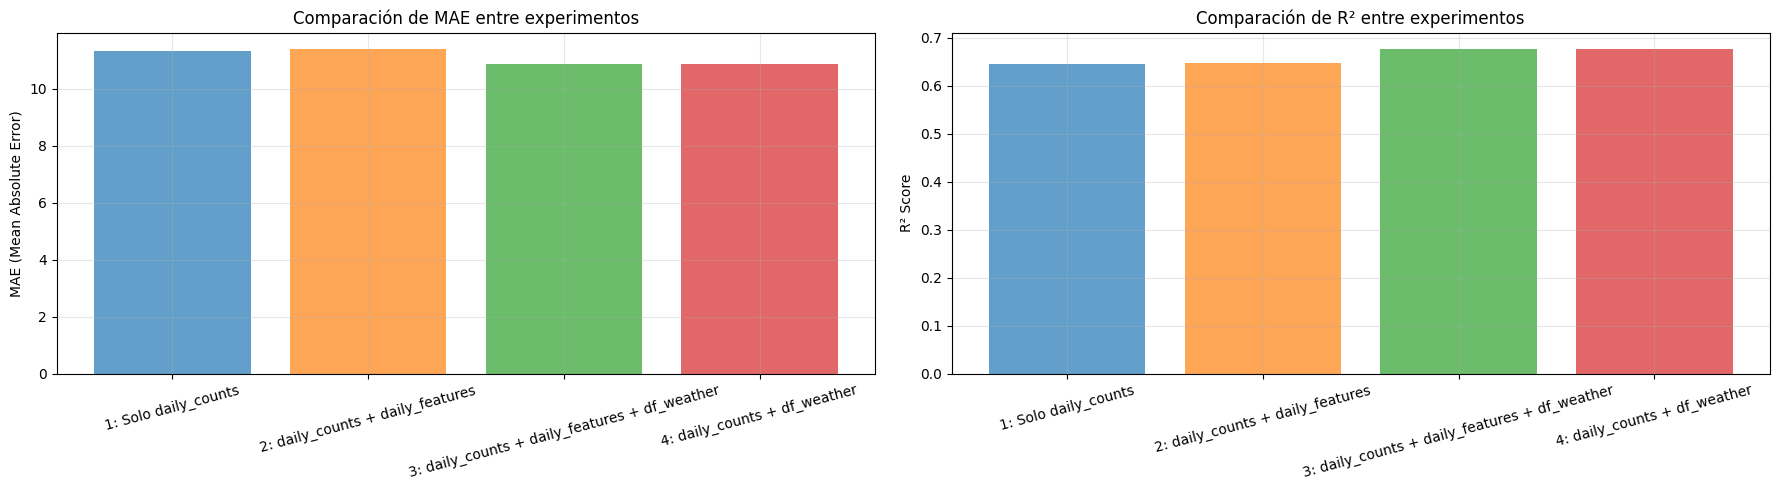


MEJOR MODELO: 3: daily_counts + daily_features + df_weather
MAE: 10.86
R²: 0.676


In [11]:
# ============================================================================
# COMPARACIÓN DE RESULTADOS
# ============================================================================
print("\n" + "=" * 70)
print("COMPARACIÓN DE RESULTADOS DE LOS CUATRO EXPERIMENTOS")
print("=" * 70)

# Crear tabla comparativa
comparison_df = pd.DataFrame({
    'Experimento': [
        '1: Solo daily_counts',
        '2: daily_counts + daily_features',
        '3: daily_counts + daily_features + df_weather',
        '4: daily_counts + df_weather'
    ],
    'MAE': [mae_exp1, mae_exp2, mae_exp3, mae_exp4],
    'R²': [r2_exp1, r2_exp2, r2_exp3, r2_exp4],
    'Features': [
        len(feature_cols_exp1),
        len(feature_cols_exp2),
        len(feature_cols_exp3),
        len(feature_cols_exp4)
    ]
})

print("\nTabla comparativa:")
print(comparison_df.to_string(index=False))

# Visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Gráfico de barras para MAE
axes[0].bar(comparison_df['Experimento'], comparison_df['MAE'], 
            color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red'], alpha=0.7)
axes[0].set_ylabel('MAE (Mean Absolute Error)')
axes[0].set_title('Comparación de MAE entre experimentos')
axes[0].tick_params(axis='x', rotation=15)
axes[0].grid(True, alpha=0.3)

# Gráfico de barras para R²
axes[1].bar(comparison_df['Experimento'], comparison_df['R²'], 
            color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red'], alpha=0.7)
axes[1].set_ylabel('R² Score')
axes[1].set_title('Comparación de R² entre experimentos')
axes[1].tick_params(axis='x', rotation=15)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Determinar el mejor modelo
best_idx = comparison_df['MAE'].idxmin()
print(f"\n{'=' * 70}")
print(f"MEJOR MODELO: {comparison_df.loc[best_idx, 'Experimento']}")
print(f"MAE: {comparison_df.loc[best_idx, 'MAE']:.2f}")
print(f"R²: {comparison_df.loc[best_idx, 'R²']:.3f}")
print(f"{'=' * 70}")
